# Ion channel simulation #

#### Importing and preparing data ####

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.backend.topology import Star

import time

### 1. Defining the model ### 

#### Define time and voltage protocol ####

In [174]:
# Define basic parameters
t = np.arange(0,523,1)
v_hold = -60
v_test = np.arange(-80,70,10)
rev_potential = -90.783

# Function to obtain each individual voltage trace
def v_trace(t, v_hold, v_step):
    v_trace = []
    for ms in t:
        if ms < 25:
            v_trace.append(v_hold)
        elif ms < 275:
            v_trace.append(v_step)
        else:
            v_trace.append(-40)
    return v_trace

# Loop to get all voltage traces together in a single protocol
v_protocol = []
for v_step in v_test:
    v_step_trace = v_trace(t, v_hold, v_step)
    v_protocol.append(v_step_trace)
v_protocol = np.array(v_protocol)

#### Define model functions ####

In [198]:
# Calculate voltage-dependent rate constants
def v_dep_rate_constants(v, rates):
    #Explain how to unravel the given rates
    k0_RA, k0_AR, k0_CO, k0_OC, k0_OI, k0_IO, z_RA, z_AR, z_CO, z_OC = rates
    
    # Define biophysical constants
    F = 9648.33  # C / mol
    R = 8.314  # J / mol·K
    T = 293.15 # Degrees Kelvin
    
    # Define voltage-dependent parameters
    # The 1000 is to convert F/RT from V to mV to match the input voltage
    k_RA = k0_RA * np.exp((v / 1000) *  z_RA * (F / (R * T))) 
    k_AR = k0_AR * np.exp((v / 1000) * -z_AR * (F / (R * T)))
    k_CO = k0_CO * np.exp((v / 1000) *  z_CO * (F / (R * T)))
    k_OC = k0_OC * np.exp((v / 1000) * -z_OC * (F / (R * T)))
    k_OI = k0_OI 
    k_IO = k0_IO 

    k = [k_RA, k_AR, k_CO, k_OC, k_OI, k_IO]
    
    T = np.array([
        [-4*k[0], k[1], 0, 0, 0, 0, 0],   #c0
        [4*k[0], -k[1] -3*k[0], 2*k[1], 0, 0, 0, 0],   #c1
        [0, 3*k[0], -2*k[1] -2*k[0], 3*k[1], 0, 0, 0],   #c2
        [0, 0, 2*k[0], -3*k[1] -k[0], 4*k[1], 0, 0],   #c3
        [0, 0, 0, k[0], -4*k[1] -k[2], k[3], 0],   #c4
        [0, 0, 0, 0, k[2], -k[3] -k[4], k[5]],   #o5
        [0, 0, 0, 0, 0, k[4], -k[5]],   #i6
        ])
    return T

# Define how to calculate the open probability
def open_prob_model(P0, t, voltage, rates):
    #Unpack the state variables
    states = P0
    # Get the current voltage-dependent constants
    index = np.clip(int(t), 0, len(voltage) - 1)
    v = voltage[index]
    markov_matrix = v_dep_rate_constants(v, rates)  # Example: get the constant based on time index
    
    # Define the rate of change based on the Markov process
    d_states = np.dot(markov_matrix, states)

    return d_states
    
# Define how to calculate current
def current_model(P0, t, voltage, rates, n):
    g = (13 / 1000) # pA per mV
    i_protocol = []
    for v_step in voltage:
        v_step_trace = v_trace(t, v_hold, v_step)
        results, info = odeint(open_prob_model, P0, t, args=(v_step_trace, rates), atol=1e-5, rtol=1e-5, mxstep=15000, full_output=True)
        open_prob = results[:,5]
        current = open_prob * n * g * (np.array(v_step_trace) - rev_potential)
        i_protocol.append(current)
    current_df = pd.DataFrame(i_protocol).transpose().set_index(t)
    current_df.columns = v_test
    return current_df

#### Solve odeint ####

In [178]:
# Initial values
P0 = [1, 0, 0, 0, 0, 0, 0]
rates = (0.448, 0.043, 280.035, 1.648, 0.003, 0.00008, 0.917606, 1.4412199, 0.1443847, 0.0248558)
n = 1000

# Execute the model
current_df = current_model(P0, t, v_test, rates, n)

#### Plot the results ####

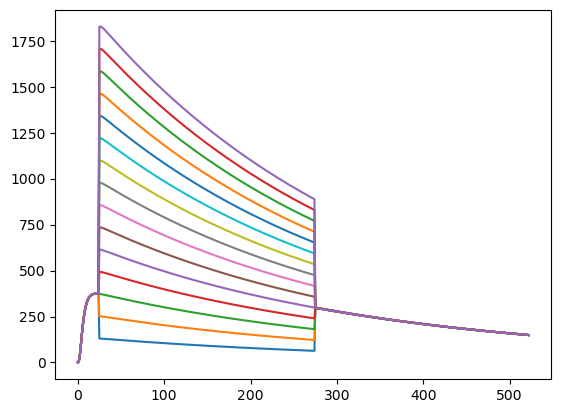

In [180]:
fig, ax = plt.subplots()
for column in current_df.columns:
    ax.plot(t, current_df[column], label=f"V = {column} mV")
#plt.savefig('KCNQ1_init_estimation.png', format='png')
plt.show()

### 2. Optimization algorithms ###
Open experimental file to compare

In [182]:
#Open experimental file
exp = pd.read_csv('Kv13_IV.csv', sep=';')
experimental_current = np.array(exp.iloc[::2, :].set_index(t).values, dtype=float)
experimental_current

array([[-4.86, -0.19,  0.45, ..., -1.84,  2.3 ,  1.79],
       [ 1.67,  0.63,  0.99, ..., -0.67,  1.65, -0.28],
       [-1.9 , -1.23, -0.67, ...,  0.5 ,  1.  , -1.29],
       ...,
       [15.64, 11.24,  9.5 , ..., 37.97, 33.24, 28.81],
       [14.11, 10.42,  9.58, ..., 36.39, 33.43, 30.64],
       [15.44,  9.66,  8.95, ..., 34.11, 33.95, 31.21]])

#### Define objective function to minimize ####

In [184]:
def objective_function(parameters, voltage, experimental_current):
    parameters = np.array(parameters)
    errors = []  # Store the error for each particle
    if parameters.ndim == 1:  # Single particle
        parameters = np.expand_dims(parameters, axis=0)  # Convert to 2D for consistent handling
    for parameters_set in parameters:  # Iterate over each particle's parameters
        rates = parameters_set[:-1]  # All except the last one are rates
        rates = rates.flatten()
        n = parameters_set[-1]       # The last parameter is the number of channels
    
        # Compute model current for this set of parameters
        model_current = current_model(P0, t, voltage, rates, n)
        model_current = model_current.to_numpy()

        # Compute the error (sum of squared differences)
        error = np.sum((experimental_current - model_current) ** 2)
        errors.append(error)  # Append the error for this particle
    return np.array(errors)  # Return the array of errors for all particles

#### Golden Section Search (GSS) ####
A technique for finding the extremum (minimum or maximum) of a unimodal function by successively narrowing the range of values.

In [186]:
# Definition of the GSS function
def golden_section_search(f, a, b, tol=1e-5):
    invphi = (np.sqrt(5) - 1) / 2  # 1/phi
    invphi2 = (3 - np.sqrt(5)) / 2  # 1/phi^2
    h = b - a
    if h <= tol:
        return (a + b) / 2

    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))

    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)

    for _ in range(n - 1):
        if yc < yd:
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)

    if yc < yd:
        return (a + d) / 2
    else:
        return (c + b) / 2

# GSS implementation for full particle optimization (optimizing all parameters simultaneously)
def optimize_parameters_gss(best_params, lb, ub, voltage, experimental_current, tol=1e-5):
    refined_params = best_params.copy()

    for i in range(len(best_params)):
        def f(x):
            params = refined_params.copy()
            params[i] = x
            return objective_function(params, voltage, experimental_current)

        # Use GSS to optimize the i-th parameter
        refined_params[i] = golden_section_search(f, lb[i], ub[i], tol)

    return refined_params

#### Particle Swarm Optimization (PSO) ####
A global optimization algorithm inspired by the social behavior of birds flocking or fish schooling.

In [188]:
# Define iterative PSO + GSS optimization
def pso_gss_optimization(initial_positions, lb, ub, iterations, generations, voltage, experimental_current):
    bounds = (lb, ub)
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
    error_history = []

    # Initialize optimizer
    optimizer = ps.single.general_optimizer.GeneralOptimizerPSO(n_particles=n_particles, dimensions=len(lb), options=options, topology=Star(), bounds=bounds, init_pos=initial_positions)
    
    for gen in range(generations):
        print(f"Generation {gen + 1}")

        # Perform PSO
        cost, best_pos = optimizer.optimize(lambda parameters: objective_function(parameters, voltage, experimental_current), iters=iterations)
        error = objective_function(best_pos, voltage, experimental_current)[0]  # Best position is a single particle
        error_history.append(error)
        
        # Refine with GSS
        refined_params = optimize_parameters_gss(best_pos, lb, ub, voltage, experimental_current)

        # Update the initial positions with the refined parameters
        optimizer.swarm.position = np.random.uniform(low=lb, high=ub, size=(n_particles, len(lb)))
        optimizer.swarm.position[:, :] = refined_params  # Set all particles to refined parameters

        
    # Return the final optimized parameters and error
    
    final_cost = objective_function([refined_params], voltage, experimental_current)[0]
    return refined_params, final_cost, error_history

#### Execute the optimization protocol ####

In [190]:
# Input initial values for PSO
P0 = [1, 0, 0, 0, 0, 0, 0]
estimated_params = np.array([0.448, 0.043, 280.035, 1.648, 0.003, 0.00008, 0.917606, 1.4412199, 0.1443847, 0.248558, 5200])
lb = np.array([0.01, 0.001, 1,  0.01, 0.00001, 1e-8,  0.001, 0.001, 0.001, 0.001,   100])
ub = np.array([2,    2,   500, 5,     1,       0.001, 2.5,   2.5,   2.5,   2.5,   10000])

In [200]:
# Define optimization parameters
generations = 10  # Number of generations
iterations = 1  # Iterations per generation
n_particles = 10
initial_positions = np.random.normal(loc=estimated_params, scale=(0.3*np.abs(estimated_params)), size=(n_particles, len(estimated_params)))
initial_positions = np.clip(initial_positions, lb, ub)

# Run PSO + GSS optimization
start_time = time.time()
final_params, final_error, error_history = pso_gss_optimization(initial_positions, lb, ub, iterations, generations, voltage=v_test, experimental_current=experimental_current)
end_time = time.time()

#Output
elapsed_time = end_time - start_time
print(f"Total time taken for optimization: {elapsed_time:.2f} seconds")
print("Final Parameters:", final_params)
print("Final Error:", final_error)

2024-09-30 21:16:15,446 - pyswarms.single.general_optimizer - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Generation 1


pyswarms.single.general_optimizer: 100%|████████████████|1/1, best_cost=1.41e+10
2024-09-30 21:16:19,199 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 14062369539.221169, best pos: [4.21071070e-01 4.05582276e-02 1.54466304e+02 1.84247488e+00
 2.51439303e-03 8.46838112e-05 8.16260601e-01 1.52190423e+00
 1.06607331e-01 3.70254012e-01 4.34504518e+03]
2024-09-30 21:18:20,701 - pyswarms.single.general_optimizer - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Generation 2


pyswarms.single.general_optimizer: 100%|█████████████████|1/1, best_cost=3.36e+9
2024-09-30 21:18:24,955 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 3361218661.429155, best pos: [1.27424358e-01 1.20248518e-01 9.25375080e+01 1.84324318e+00
 2.07603930e-03 4.07526872e-06 2.49998619e+00 2.49997481e+00
 2.49988761e+00 2.49997129e+00 5.26317146e+03]
2024-09-30 21:20:42,157 - pyswarms.single.general_optimizer - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Generation 3


pyswarms.single.general_optimizer: 100%|█████████████████|1/1, best_cost=2.82e+9
2024-09-30 21:20:46,494 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 2824957376.2438555, best pos: [1.23138963e-01 1.41486420e-01 7.16028575e+01 1.85417446e+00
 1.91857634e-03 4.07526872e-06 2.49999540e+00 2.49999540e+00
 2.49993230e+00 2.49998619e+00 5.50194593e+03]
2024-09-30 21:23:21,680 - pyswarms.single.general_optimizer - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Generation 4


pyswarms.single.general_optimizer: 100%|█████████████████|1/1, best_cost=2.18e+9
2024-09-30 21:23:26,747 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 2176009300.6058283, best pos: [1.41413609e-01 1.61715878e-01 5.85117911e+01 1.86394467e+00
 2.10725046e-03 4.07526872e-06 2.49999540e+00 2.49998050e+00
 2.49991740e+00 2.49995071e+00 5.68969759e+03]
2024-09-30 21:26:09,049 - pyswarms.single.general_optimizer - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Generation 5


pyswarms.single.general_optimizer: 100%|█████████████████|1/1, best_cost=1.67e+9
2024-09-30 21:26:13,891 - pyswarms.single.general_optimizer - INFO - Optimization finished | best cost: 1673799138.2982044, best pos: [1.63242982e-01 1.80131013e-01 5.07634349e+01 1.87038371e+00
 2.28627980e-03 4.07526872e-06 2.49999540e+00 2.49996560e+00
 2.49967989e+00 2.49998971e+00 5.81366866e+03]


KeyboardInterrupt: 

In [ ]:
plt.plot(error_history)
plt.xlabel('Iteration Number')
plt.ylabel('Error')
plt.title('Error in Each Iteration of PSO-GSS')
plt.grid()
#plt.savefig('Kv13_error.png', format='png')
plt.show()

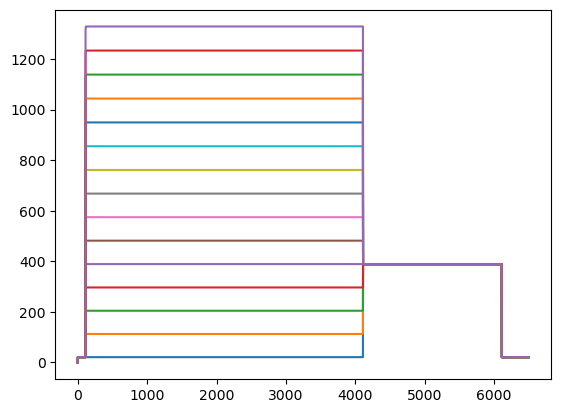

In [23]:
# Initial values
P0 = [1, 0, 0, 0, 0, 0]
rates = (1.60217915e-02,  4.46269078e-03,  1.46317730e-03,  1.09738298e-03,
  6.73061560e-03,  1.82897163e-03, -1.66807039e+00, -2.93898079e+00,
 -2.51379391e+00, -2.79895565e+00,  2.12989895e-02,  1.59742421e-01,
  )
n = 9.94960567e+04

# Execute the model
current_df = current_model(P0, t, v_test, rates, n)

# Plot the results
fig, ax = plt.subplots()
for column in current_df.columns:
    ax.plot(t, current_df[column], label=f"V = {column} mV")
plt.show()

In [54]:
print(lb)
print(ub)
print(rates)

[ 1.200e-04  6.300e-06  1.900e-05  1.300e-05  1.400e-04  1.118e-01
  6.200e+00 -5.500e+04  6.600e+00 -3.400e+04  1.552e-01  1.700e-03
  3.030e-02  3.100e-04  1.360e-02  2.110e-02  1.000e+01]
[ 1.200e+00  6.300e-02  1.900e-01  1.300e-01  1.400e+00  1.118e+03
  6.200e+04 -5.500e+00  6.600e+04 -3.400e+00  1.552e+03  1.700e+01
  3.030e+02  3.100e+00  1.360e+02  2.110e+02  1.000e+05]
(0.0010148258, 5.32783544e-05, 0.000160680751, 0.000109939462, 0.00118396343, 0.945479369, 52.4326663, -54958.9872, 55.8154189, -33974.6466, 1.31250803, 0.0143766988, 0.256243514, 0.00262163331, 0.115013591, 0.178440203)


In [134]:
def objective_function_2D(parameters, voltage, experimental_current):
    parameters = np.array(parameters)
    rates = parameters[:-1]  
    n = parameters[-1]       

    model_current = current_model(P0, t, voltage, rates, n)
    model_current = model_current.to_numpy()

    # Compute the error (sum of squared differences)
    error = np.sum(np.abs(experimental_current - model_current))

    return error  # Return the array of errors for all particles

def plot_2D(param1_array, param2_array):
    # Unpack
    param1_idx, param1_value, param1_lb, param1_ub, param1_name = param1_array
    param2_idx, param2_value, param2_lb, param2_ub, param2_name = param2_array
    
    # Create a grid of values for the two parameters
    param1_values = np.linspace(param1_lb, param1_ub, 100)
    param2_values = np.linspace(param2_lb, param2_ub, 100)

    # Create a meshgrid for 2D plotting
    P1, P2 = np.meshgrid(param1_values, param2_values)

    # Initialize a matrix to store the error values
    error_values = np.zeros_like(P1)

    # Loop through the grid and calculate the error at each point
    for i in range(P1.shape[0]):
        for j in range(P1.shape[1]):
            # Use estimated_params for other parameters, vary only param1 and param2
            params = np.copy(estimated_params)
            params[param1_idx] = P1[i, j]
            params[param2_idx] = P2[i, j]
            
            # Calculate the error for the current set of parameters
            error_values[i, j] = objective_function_2D(params, v_test, experimental_current)

    np.savetxt(f'abs_nolog_p{param1_idx}_p{param2_idx}_v1.csv', error_values, delimiter = ',')
    
    # Plot the 2D error landscape using a contour plot
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(P1, P2, error_values, 20, cmap='viridis')
    plt.colorbar(contour)
    plt.xscale('log')
    #plt.yscale('log')
    
    plt.xlabel(f'Parameter {param1_idx}: {param1_name}')
    plt.ylabel(f'Parameter {param2_idx}: {param2_name}')
    plt.title('2D Error Landscape')
    plt.savefig(f'abs_nolog_p{param1_idx}_p{param2_idx}_v1.png', format='png')
    plt.show()

In [ ]:
# RI transition
a = 1
b = 7
params = np.copy(estimated_params)
param1_array = [a, params[a], lb[a], ub[a], 'k0_IR']
param2_array = [b, params[b], lb[b], ub[b], 'z_IR']
plot_2D(param1_array, param2_array)